In [1]:
pip install squarify

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install plotly

  Created wheel for retrying: filename=retrying-1.3.3-cp37-none-any.whl size=11435 sha256=bb92a2747f6d0e0bac11ef5490a97ace6d5ae257afd303e0a2b1c611547255da
  Stored in directory: C:\Users\admin\AppData\Local\pip\Cache\wheels\d7\a9\33\acc7b709e2a35caa7d4cae442f6fe6fbf2c43f80823d46460c
Successfully built retrying
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

# Plots
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.tools as tls
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)
import squarify

# Data processing, metrics and modeling
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score
import lightgbm as lgbm
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict
from yellowbrick.classifier import DiscriminationThreshold

# Stats
import scipy.stats as ss
from scipy import interp
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

# Time
from contextlib import contextmanager
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

#ignore warning messages 
import warnings
warnings.filterwarnings('ignore') 

In [2]:
data = pd.read_csv('c:/users/admin/Downloads/diabetes.csv')

In [3]:
display(data.info(),data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


None

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

#------------COUNT-----------------------
def target_count():
    trace = go.Bar( x = data['Outcome'].value_counts().values.tolist(), 
                    y = ['healthy','diabetic' ], 
                    orientation = 'h', 
                    text=data['Outcome'].value_counts().values.tolist(), 
                    textfont=dict(size=15),
                    textposition = 'auto',
                    opacity = 0.8,marker=dict(
                    color=['lightskyblue', 'gold'],
                    line=dict(color='#000000',width=1.5)))

    layout = dict(title =  'Count of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

#------------PERCENTAGE-------------------
def target_percent():
    trace = go.Pie(labels = ['healthy','diabetic'], values = data['Outcome'].value_counts(), 
                   textfont=dict(size=15), opacity = 0.8,
                   marker=dict(colors=['lightskyblue', 'gold'], 
                               line=dict(color='#000000', width=1.5)))


    layout = dict(title =  'Distribution of Outcome variable')

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [5]:
target_count()
target_percent()

In [6]:
data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = data[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [7]:
def missing_plot(dataset, key) :
    null_feat = pd.DataFrame(len(dataset[key]) - dataset.isnull().sum(), columns = ['Count'])
    percentage_null = pd.DataFrame((len(dataset[key]) - (len(dataset[key]) - dataset.isnull().sum()))/len(dataset[key])*100, columns = ['Count'])
    percentage_null = percentage_null.round(2)

    trace = go.Bar(x = null_feat.index, y = null_feat['Count'] ,opacity = 0.8, text = percentage_null['Count'],  textposition = 'auto',marker=dict(color = '#7EC0EE',
            line=dict(color='#000000',width=1.5)))

    layout = dict(title =  "Missing Values (count & %)")

    fig = dict(data = [trace], layout=layout)
    py.iplot(fig)

In [8]:
missing_plot(data, 'Outcome')

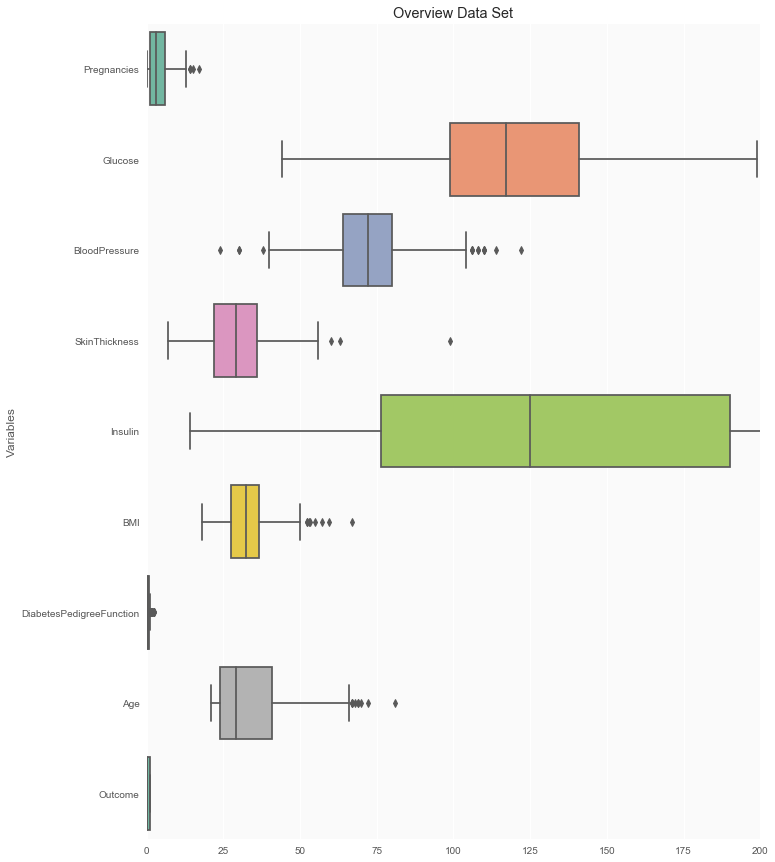

In [9]:
plt.style.use('ggplot') # Using ggplot2 style visuals 

f, ax = plt.subplots(figsize=(11, 15))

ax.set_facecolor('#fafafa')
ax.set(xlim=(-.05, 200))
plt.ylabel('Variables')
plt.title("Overview Data Set")
ax = sns.boxplot(data = data, 
  orient = 'h', 
  palette = 'Set2')

In [10]:
def correlation_plot():
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [11]:
correlation_plot()

In [12]:
def median_target(var):   
    temp = data[data[var].notnull()]
    temp = temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
    return temp

In [13]:
def plot_distribution(data_select, size_bin) :  
    # 2 datasets
    tmp1 = D[data_select]
    tmp2 = H[data_select]
    hist_data = [tmp1, tmp2]
    
    group_labels = ['diabetic', 'healthy']
    colors = ['#FFD700', '#7EC0EE']

    fig = ff.create_distplot(hist_data, group_labels, colors = colors, show_hist = True, bin_size = size_bin, curve_type='kde')
    
    fig['layout'].update(title = data_select)

    py.iplot(fig, filename = 'Density plot')

In [14]:
plot_distribution('Insulin', 0)

In [15]:
median_target('Insulin')

,Outcome,Insulin
0,0,102.5
1,1,169.5


In [16]:
data.loc[(data['Outcome'] == 0 ) & (data['Insulin'].isnull()), 'Insulin'] = 102.5
data.loc[(data['Outcome'] == 1 ) & (data['Insulin'].isnull()), 'Insulin'] = 169.5

In [17]:
plot_distribution('Glucose', 0)

In [18]:
median_target('Glucose')

,Outcome,Glucose
0,0,107.0
1,1,140.0


In [19]:
data.loc[(data['Outcome'] == 0 ) & (data['Glucose'].isnull()), 'Glucose'] = 107
data.loc[(data['Outcome'] == 1 ) & (data['Glucose'].isnull()), 'Glucose'] = 140

In [20]:
plot_distribution('SkinThickness', 10)

In [21]:
median_target('SkinThickness')

,Outcome,SkinThickness
0,0,27.0
1,1,32.0


In [22]:
data.loc[(data['Outcome'] == 0 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 27
data.loc[(data['Outcome'] == 1 ) & (data['SkinThickness'].isnull()), 'SkinThickness'] = 32

In [23]:
plot_distribution('BloodPressure', 5)

In [24]:
median_target('BloodPressure')

,Outcome,BloodPressure
0,0,70.0
1,1,74.5


In [25]:
data.loc[(data['Outcome'] == 0 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 70
data.loc[(data['Outcome'] == 1 ) & (data['BloodPressure'].isnull()), 'BloodPressure'] = 74.5

In [26]:
plot_distribution('BMI', 0)

In [27]:
median_target('BMI')

,Outcome,BMI
0,0,30.1
1,1,34.3


In [28]:
data.loc[(data['Outcome'] == 0 ) & (data['BMI'].isnull()), 'BMI'] = 30.1
data.loc[(data['Outcome'] == 1 ) & (data['BMI'].isnull()), 'BMI'] = 34.3

In [29]:
plot_distribution('Age', 0)
plot_distribution('Pregnancies', 0)
plot_distribution('DiabetesPedigreeFunction', 0)

In [30]:
missing_plot(data, 'Outcome')

In [31]:
def plot_feat1_feat2(feat1, feat2) :  
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    trace0 = go.Scatter(
        x = D[feat1],
        y = D[feat2],
        name = 'diabetic',
        mode = 'markers', 
        marker = dict(color = '#FFD700',
            line = dict(
                width = 1)))

    trace1 = go.Scatter(
        x = H[feat1],
        y = H[feat2],
        name = 'healthy',
        mode = 'markers',
        marker = dict(color = '#7EC0EE',
            line = dict(
                width = 1)))

    layout = dict(title = feat1 +" "+"vs"+" "+ feat2,
                  yaxis = dict(title = feat2,zeroline = False),
                  xaxis = dict(title = feat1, zeroline = False)
                 )

    plots = [trace0, trace1]

    fig = dict(data = plots, layout=layout)
    py.iplot(fig)

In [32]:
def barplot(var_select, sub) :
    tmp1 = data[(data['Outcome'] != 0)]
    tmp2 = data[(data['Outcome'] == 0)]
    tmp3 = pd.DataFrame(pd.crosstab(data[var_select],data['Outcome']), )
    tmp3['% diabetic'] = tmp3[1] / (tmp3[1] + tmp3[0]) * 100

    color=['lightskyblue','gold' ]
    trace1 = go.Bar(
        x=tmp1[var_select].value_counts().keys().tolist(),
        y=tmp1[var_select].value_counts().values.tolist(),
        text=tmp1[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='diabetic',opacity = 0.8, marker=dict(
        color='gold',
        line=dict(color='#000000',width=1)))

    
    trace2 = go.Bar(
        x=tmp2[var_select].value_counts().keys().tolist(),
        y=tmp2[var_select].value_counts().values.tolist(),
        text=tmp2[var_select].value_counts().values.tolist(),
        textposition = 'auto',
        name='healthy', opacity = 0.8, marker=dict(
        color='lightskyblue',
        line=dict(color='#000000',width=1)))
    
    trace3 =  go.Scatter(   
        x=tmp3.index,
        y=tmp3['% diabetic'],
        yaxis = 'y2',
        name='% diabetic', opacity = 0.6, marker=dict(
        color='black',
        line=dict(color='#000000',width=0.5
        )))

    layout = dict(title =  str(var_select)+' '+(sub),
              xaxis=dict(), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [-0, 75], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= '% diabetic'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    py.iplot(fig)

In [33]:
def plot_pie(var_select, sub) :
    D = data[(data['Outcome'] != 0)]
    H = data[(data['Outcome'] == 0)]
    
    col =['Silver', 'mediumturquoise','#CF5C36','lightblue','magenta', '#FF5D73','#F2D7EE','mediumturquoise']
    
    trace1 = go.Pie(values  = D[var_select].value_counts().values.tolist(),
                    labels  = D[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5, 
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [.0,.48]),
                    name    = "Diabetic",
                    marker  = dict(colors = col, line = dict(width = 1.5)))
    trace2 = go.Pie(values  = H[var_select].value_counts().values.tolist(),
                    labels  = H[var_select].value_counts().keys().tolist(),
                    textfont=dict(size=15), opacity = 0.8,
                    hole = 0.5,
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 1.5)),
                    domain  = dict(x = [.52,1]),
                    name    = "Healthy" )

    layout = go.Layout(dict(title = var_select + " distribution by target <br>"+(sub),
                            annotations = [ dict(text = "Diabetic"+" : "+"268",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .22, y = -0.1),
                                            dict(text = "Healthy"+" : "+"500",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .8,y = -.1)]))
                                          

    fig  = go.Figure(data = [trace1,trace2],layout = layout)
    py.iplot(fig)

In [34]:
plot_feat1_feat2('Glucose','Age')

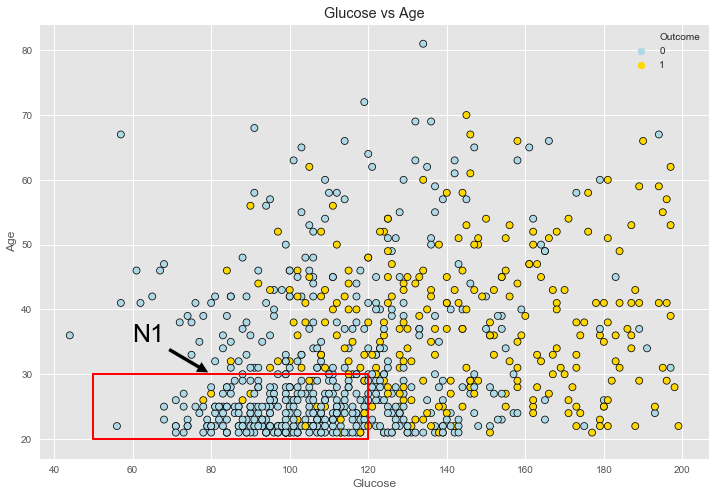

In [35]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['Age'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N1', size=25, color='black', xy=(80, 30), xytext=(60, 35),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([50, 120], [30, 30], linewidth=2, color = 'red')
plt.plot([120, 120], [20, 30], linewidth=2, color = 'red')
plt.plot([50, 120], [20, 20], linewidth=2, color = 'red')
plt.plot([50, 50], [20, 30], linewidth=2, color = 'red')
plt.title('Glucose vs Age')
plt.show()

In [36]:
data.loc[:,'N1']=0
data.loc[(data['Age']<=30) & (data['Glucose']<=120),'N1']=1

In [37]:
barplot('N1', ':Glucose <= 120 and Age <= 30')

In [38]:
plot_pie('N1', '(Glucose <= 120 and Age <= 30)')

In [39]:
data.loc[:,'N2']=0
data.loc[(data['BMI']<=30),'N2']=1

In [40]:
barplot('N2', ': BMI <= 30')

In [41]:
plot_pie('N2', 'BMI <= 30')

In [42]:
plot_feat1_feat2('Pregnancies','Age')

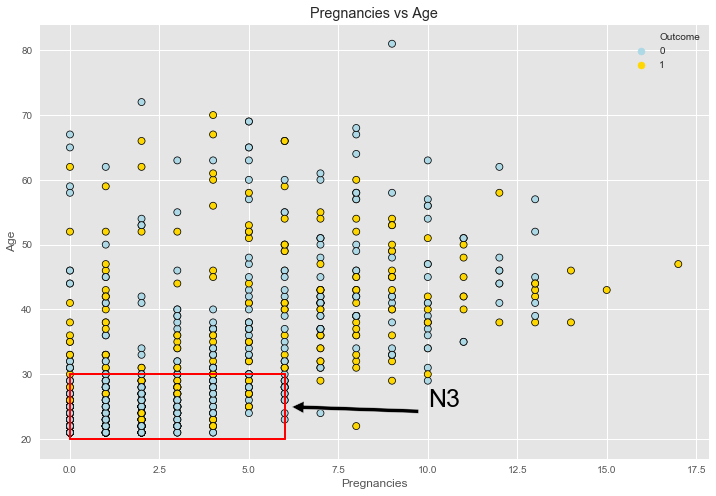

In [43]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Pregnancies'], y = data['Age'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N3', size=25, color='black', xy=(6, 25), xytext=(10, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([0, 6], [30, 30], linewidth=2, color = 'red')
plt.plot([6, 6], [20, 30], linewidth=2, color = 'red')
plt.plot([0, 6], [20, 20], linewidth=2, color = 'red')
plt.plot([0, 0], [20, 30], linewidth=2, color = 'red')
plt.title('Pregnancies vs Age')
plt.show()

In [44]:
data.loc[:,'N3']=0
data.loc[(data['Age']<=30) & (data['Pregnancies']<=6),'N3']=1

In [45]:
barplot('N3', ': Age <= 30 and Pregnancies <= 6')

In [46]:
plot_pie('N3', 'Age <= 30 and Pregnancies <= 6')

In [47]:
plot_feat1_feat2('Glucose','BloodPressure')

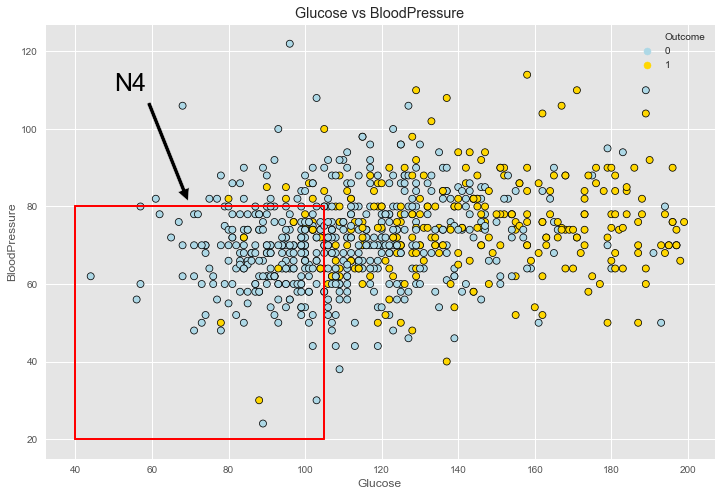

In [48]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['BloodPressure'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N4', size=25, color='black', xy=(70, 80), xytext=(50, 110),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([40, 105], [80, 80], linewidth=2, color = 'red')
plt.plot([40, 40], [20, 80], linewidth=2, color = 'red')
plt.plot([40, 105], [20, 20], linewidth=2, color = 'red')
plt.plot([105, 105], [20, 80], linewidth=2, color = 'red')
plt.title('Glucose vs BloodPressure')
plt.show()

In [49]:
data.loc[:,'N4']=0
data.loc[(data['Glucose']<=105) & (data['BloodPressure']<=80),'N4']=1

In [50]:
barplot('N4', ': Glucose <= 105 and BloodPressure <= 80')

In [51]:
plot_pie('N4', 'Glucose <= 105 and BloodPressure <= 80')

In [52]:
data.loc[:,'N5']=0
data.loc[(data['SkinThickness']<=20) ,'N5']=1

In [53]:
barplot('N5', ':SkinThickness <= 20')

In [54]:
plot_pie('N5', 'SkinThickness <= 20')

In [55]:
plot_feat1_feat2('SkinThickness','BMI')

In [56]:
data.loc[:,'N6']=0
data.loc[(data['BMI']<30) & (data['SkinThickness']<=20),'N6']=1

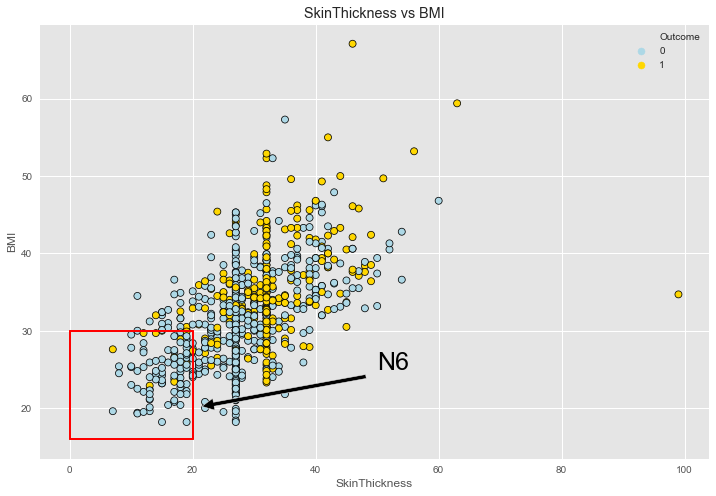

In [57]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['SkinThickness'], y = data['BMI'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N6', size=25, color='black', xy=(20, 20), xytext=(50, 25),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([0, 20], [30, 30], linewidth=2, color = 'red')
plt.plot([0, 0], [16, 30], linewidth=2, color = 'red')
plt.plot([0, 20], [16, 16], linewidth=2, color = 'red')
plt.plot([20, 20], [16, 30], linewidth=2, color = 'red')
plt.title('SkinThickness vs BMI')
plt.show()


In [58]:
barplot('N6', ': BMI < 30 and SkinThickness <= 20')

In [59]:
plot_pie('N6', 'BMI < 30 and SkinThickness <= 20')

In [60]:
plot_feat1_feat2('Glucose','BMI')

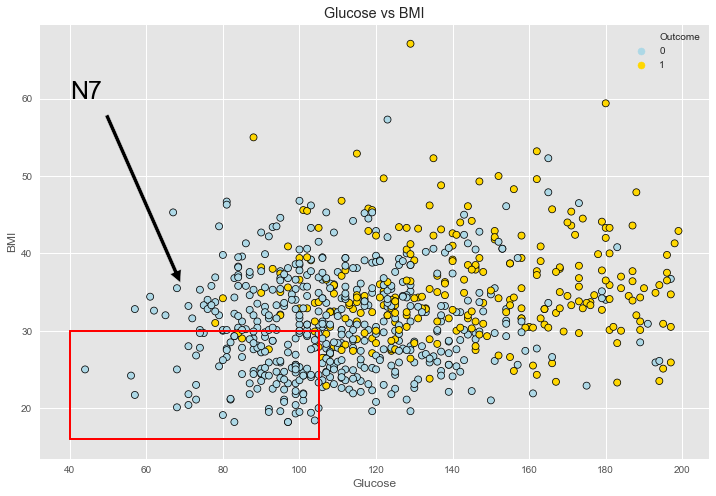

In [61]:
palette ={0 : 'lightblue', 1 : 'gold'}
edgecolor = 'black'

fig = plt.figure(figsize=(12,8))

ax1 = sns.scatterplot(x = data['Glucose'], y = data['BMI'], hue = "Outcome",
                    data = data, palette = palette, edgecolor=edgecolor)

plt.annotate('N7', size=25, color='black', xy=(70, 35), xytext=(40, 60),
            arrowprops=dict(facecolor='black', shrink=0.05),
            )
plt.plot([105, 105], [16, 30], linewidth=2, color = 'red')
plt.plot([40, 40], [16, 30], linewidth=2, color = 'red')
plt.plot([40, 105], [16, 16], linewidth=2, color = 'red')
plt.plot([40, 105], [30, 30], linewidth=2, color = 'red')
plt.title('Glucose vs BMI')
plt.show()

In [62]:
data.loc[:,'N7']=0
data.loc[(data['Glucose']<=105) & (data['BMI']<=30),'N7']=1

In [63]:
barplot('N7', ': Glucose <= 105 and BMI <= 30')

In [64]:
plot_pie('N7', 'Glucose <= 105 and BMI <= 30')

In [65]:
plot_distribution('Insulin', 0)

In [66]:
data.loc[:,'N9']=0
data.loc[(data['Insulin']<200),'N9']=1

In [67]:
barplot('N9', ': Insulin < 200')

In [68]:
plot_pie('N9', 'Insulin < 200')

In [69]:
data.loc[:,'N10']=0
data.loc[(data['BloodPressure']<80),'N10']=1

In [70]:
barplot('N10', ': BloodPressure < 80')

In [71]:
plot_pie('N10', 'BloodPressure < 80')

In [72]:
plot_distribution('Pregnancies', 0)

In [73]:
data.loc[:,'N11']=0
data.loc[(data['Pregnancies']<4) & (data['Pregnancies']!=0) ,'N11']=1

In [74]:
barplot('N11', ': Pregnancies > 0 and < 4')

In [75]:
plot_pie('N11', 'Pregnancies > 0 and < 4')

In [76]:
data['N0'] = data['BMI'] * data['SkinThickness']

data['N8'] =  data['Pregnancies'] / data['Age']

data['N13'] = data['Glucose'] / data['DiabetesPedigreeFunction']

data['N12'] = data['Age'] * data['DiabetesPedigreeFunction']

data['N14'] = data['Age'] / data['Insulin']

In [77]:
D = data[(data['Outcome'] != 0)]
H = data[(data['Outcome'] == 0)]

In [78]:
plot_distribution('N0', 0)

In [79]:
data.loc[:,'N15']=0
data.loc[(data['N0']<1034) ,'N15']=1

In [80]:
barplot('N15', ': N0 < 1034')

In [81]:
plot_pie('N15', 'N0 < 1034')

In [82]:
target_col = ["Outcome"]
cat_cols   = data.nunique()[data.nunique() < 12].keys().tolist()
cat_cols   = [x for x in cat_cols ]
#numerical columns
num_cols   = [x for x in data.columns if x not in cat_cols + target_col]
#Binary columns with 2 values
bin_cols   = data.nunique()[data.nunique() == 2].keys().tolist()
#Columns more than 2 values
multi_cols = [i for i in cat_cols if i not in bin_cols]

#Label encoding Binary columns
le = LabelEncoder()
for i in bin_cols :
    data[i] = le.fit_transform(data[i])
    
#Duplicating columns for multi value columns
data = pd.get_dummies(data = data,columns = multi_cols )

#Scaling Numerical columns
std = StandardScaler()
scaled = std.fit_transform(data[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)

#dropping original values merging scaled values for numerical columns
df_data_og = data.copy()
data = data.drop(columns = num_cols,axis = 1)
data = data.merge(scaled,left_index=True,right_index=True,how = "left")

In [83]:
def correlation_plot():
    #correlation
    correlation = data.corr()
    #tick labels
    matrix_cols = correlation.columns.tolist()
    #convert to array
    corr_array  = np.array(correlation)
    trace = go.Heatmap(z = corr_array,
                       x = matrix_cols,
                       y = matrix_cols,
                       colorscale='Viridis',
                       colorbar   = dict() ,
                      )
    layout = go.Layout(dict(title = 'Correlation Matrix for variables',
                            #autosize = False,
                            #height  = 1400,
                            #width   = 1600,
                            margin  = dict(r = 0 ,l = 100,
                                           t = 0,b = 100,
                                         ),
                            yaxis   = dict(tickfont = dict(size = 9)),
                            xaxis   = dict(tickfont = dict(size = 9)),
                           )
                      )
    fig = go.Figure(data = [trace],layout = layout)
    py.iplot(fig)

In [84]:
correlation_plot()

In [85]:
X = data.drop('Outcome', 1)
y = data['Outcome']

In [86]:
def model_performance(model, subtitle) :   
    #Kfold
    cv = KFold(n_splits=5,shuffle=False, random_state = 42)
    y_real = []
    y_proba = []
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)
    i = 1
    
    for train,test in cv.split(X,y):
        model.fit(X.iloc[train], y.iloc[train])
        pred_proba = model.predict_proba(X.iloc[test])
        precision, recall, _ = precision_recall_curve(y.iloc[test], pred_proba[:,1])
        y_real.append(y.iloc[test])
        y_proba.append(pred_proba[:,1])
        fpr, tpr, t = roc_curve(y[test], pred_proba[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc) 
    
    # Confusion matrix
    y_pred = cross_val_predict(model, X, y, cv=5)
    conf_matrix = confusion_matrix(y, y_pred)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)
    
    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto', textfont=dict(color='black'),
                    orientation = 'h', opacity = 1, marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))

    #Roc curve
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    trace3 = go.Scatter(x=mean_fpr, y=mean_tpr,
                        name = "Roc : " ,
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    #Precision - recall curve
    y_real = y
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)

    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
    mean_auc=round(mean_auc,3)
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False,
                          specs=[[{}, {}], 
                                 [{}, {}]],
                          subplot_titles=('Confusion Matrix',
                                          'Metrics',
                                          'ROC curve'+" "+ '('+ str(mean_auc)+')',
                                          'Precision - Recall curve',
                                          ))
    #Trace and layout
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report (5 folds)</b><br>'+subtitle,
                        autosize = False, height = 830, width = 830,
                        plot_bgcolor = 'black',
                        paper_bgcolor = 'black',
                        margin = dict(b = 195), font=dict(color='white'))
    fig["layout"]["xaxis1"].update(color = 'white')
    fig["layout"]["yaxis1"].update(color = 'white')
    fig["layout"]["xaxis2"].update((dict(range=[0, 1], color = 'white')))
    fig["layout"]["yaxis2"].update(color = 'white')
    fig["layout"]["xaxis3"].update(dict(title = "false positive rate"), color = 'white')
    fig["layout"]["yaxis3"].update(dict(title = "true positive rate"),color = 'white')
    fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05],color = 'white')
    fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05],color = 'white')
    for i in fig['layout']['annotations']:
        i['font'] = titlefont=dict(color='white', size = 14)
    py.iplot(fig)


In [109]:
accuracy=0
def scores_table(model, subtitle):
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    res = []
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        res.append(scores)
    df = pd.DataFrame(res).T
    df.loc['mean'] = df.mean()
    df.loc['std'] = df.std()
    df= df.rename(columns={0: 'accuracy', 1:'precision', 2:'recall',3:'f1',4:'roc_auc'})

    trace = go.Table(
        header=dict(values=['<b>Fold', '<b>Accuracy', '<b>Precision', '<b>Recall', '<b>F1 score', '<b>Roc auc'],
                    line = dict(color='#7D7F80'),
                    fill = dict(color='#a1c3d1'),
                    align = ['center'],
                    font = dict(size = 15)),
        cells=dict(values=[('1','2','3','4','5','mean', 'std'),
                           np.round(df['accuracy'],3),
                           np.round(df['precision'],3),
                           np.round(df['recall'],3),
                           np.round(df['f1'],3),
                           np.round(df['roc_auc'],3)],
                   line = dict(color='#7D7F80'),
                   fill = dict(color='#EDFAFF'),
                   align = ['center'], font = dict(size = 15)))

    layout = dict(width=800, height=400, title = '<b>Cross Validation - 5 folds</b><br>'+subtitle, font = dict(size = 15))
    fig = dict(data=[trace], layout=layout)
    print("Accuracy = %.3f"%(df.loc['mean']['accuracy']))
    py.iplot(fig, filename = 'styled_table')

In [88]:
random_state=42

fit_params = {"early_stopping_rounds" : 100, 
             "eval_metric" : 'auc', 
             "eval_set" : [(X,y)],
             'eval_names': ['valid'],
             'verbose': 0,
             'categorical_feature': 'auto'}

param_test = {'learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4],
              'n_estimators' : [100, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000],
              'num_leaves': sp_randint(6, 50), 
              'min_child_samples': sp_randint(100, 500), 
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'subsample': sp_uniform(loc=0.2, scale=0.8), 
              'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}

#number of combinations
n_iter = 300

#intialize lgbm and lunch the search
lgbm_clf = lgbm.LGBMClassifier(random_state=random_state, silent=True, metric='None', n_jobs=4)
grid_search = RandomizedSearchCV(
    estimator=lgbm_clf, param_distributions=param_test, 
    n_iter=n_iter,
    scoring='accuracy',
    cv=5,
    refit=True,
    random_state=random_state,
    verbose=True)

grid_search.fit(X, y, **fit_params)
opt_parameters =  grid_search.best_params_
lgbm_clf = lgbm.LGBMClassifier(**opt_parameters)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:  2.5min finished


In [110]:
model_performance(lgbm_clf, 'LightGBM')
scores_table(lgbm_clf, 'LightGBM')

Accuracy = 0.898
